In [1]:
import json
import os
import bz2
import io
from bz2 import BZ2File
import re
import numpy as np
from datetime import date, timedelta
import pandas as pd
import matplotlib.pyplot as plt



### Transform the data


The following command is here to throw useless datas in files. Since we already reduced the files, there is no need to do the compression again.

In [2]:
#! for f in data/*[0-9].jsonl.bz2; do bzcat $f | jq -c '{id: .id, type: .tp, date: .d, title: .t, fulltext: .ft}' | bzip2 > "{f%.jsonl.bz2}-reduced.jsonl.bz2" ; done

# Preparation

### List to see the data in data folder:

In [3]:
ls -la data/

total 718568
drwxr-xr-x  16 aslam  staff       512  6 mar 17:37 ./
drwxrwxrwx  39 aslam  staff      1248  7 mar 22:27 ../
-rw-r--r--@  1 aslam  staff      8196  6 mar 17:37 .DS_Store
-rwxrwxrwx   1 aslam  staff  23795907  3 mar 12:31 JDG-1980-reduced.jsonl.bz2*
-rwxrwxrwx   1 aslam  staff  21521939  3 mar 12:32 JDG-1981-reduced.jsonl.bz2*
-rwxrwxrwx   1 aslam  staff  22822888  3 mar 12:33 JDG-1982-reduced.jsonl.bz2*
-rwxrwxrwx   1 aslam  staff  25263118  3 mar 12:34 JDG-1983-reduced.jsonl.bz2*
-rwxrwxrwx   1 aslam  staff  23839962  3 mar 12:35 JDG-1984-reduced.jsonl.bz2*
-rwxrwxrwx   1 aslam  staff  22984620  3 mar 12:36 JDG-1985-reduced.jsonl.bz2*
-rwxrwxrwx   1 aslam  staff  33642024  3 mar 12:37 JDG-1986-reduced.jsonl.bz2*
-rwxrwxrwx   1 aslam  staff  29476045  3 mar 12:38 JDG-1987-reduced.jsonl.bz2*
-rwxrwxrwx   1 aslam  staff  33200405  3 mar 12:39 JDG-1988-reduced.jsonl.bz2*
-rwxrwxrwx   1 aslam  staff  30297761  3 mar 12:40 JDG-1989-reduced.jsonl.bz2*
-rwxrwxrwx   1 aslam  staff

### Reading newspaper archive data

Reminder: the data is already 'clean' and the files at hand contains only the following information:
- id
- date
- title
- type (article or advertisement)
- fulltext


Since our reduced files are in data/, we need to have the path to them:

In [4]:
input_dir = "data/" # update with your path 

In [78]:
# a helper function to get the lines from am archive
def read_jsonlines(bz2_file):
    text = bz2_file.read().decode('utf-8')
    for line in text.split('\n'):
        if line != '':
            yield line

In [79]:
#gives in string all the dates between two dates
def string_dates(date1, date2):
    result = []
    delta = date2 - date1
    
    for i in range(delta.days + 1):
        result.append(str(d1+timedelta(i)))
        
    return result

In [6]:
# a helper function to see if we have all the keywords contained in a list
# returns true if all elements in arguments are positif
def all_pos(myList):
    return all(item > 0 for item in myList)


# return true if at least one element is positif
def one_pos(myList):
    for el in myList:
        if(el > 0):
            return True
    return False


# test 
# myList = [3, 2, 5, 2, 9]
#myList2 = [3, 2, 5, 2, 9, 0]
# all_pos(myList) # True
#all_pos(myList2) # False
# one_pos(myList2) # True

In [7]:
# this function deals with an article and return the occurences (sum for all the keywords given) --> or condition
# STAT PURPOSES
def study(article, keywords):
    json_article = json.loads(article)
    full_text_str = json_article["fulltext"]
    #full_text_str = article
    flag = False # this flag will be True if at least one of the keyword is in the text
    
    length = len(keywords)
    full_occurences = [0] * length
    
    for index in range(0, length):
        print("OCCURENCES: " + full_text_str[0:30])
        occurences = len(re.findall(keywords[index], full_text_str, re.IGNORECASE))
    
        #title = json_article["id"].encode('ascii','ignore')

        if(occurences > 0):
            flag = True
            full_occurences[index] = occurences
            
    #if flag:
            #print_arrays(title, keywords, full_occurences)
            # Instead of print_arrays, we should call a function that will decide if all content are good or not
            # a similar function will return sum of list (one "or" condition, and the and the "and" condition will be checked with all_pos)
    return sum(full_occurences)




In [8]:
print("NUMBER OF ARTICLES PER ARCHIVE")
for archive in os.listdir(input_dir):
    if("JDG" in archive):
        # print(archive)
        f = BZ2File(os.path.join(input_dir, archive), 'r')
        articles = list(read_jsonlines(f))

        print(archive + ", number of articles: " + str(len(articles)))

NUMBER OF ARTICLES PER ARCHIVE
JDG-1982-reduced.jsonl.bz2, number of articles: 28867
JDG-1987-reduced.jsonl.bz2, number of articles: 36041
JDG-1983-reduced.jsonl.bz2, number of articles: 27750
JDG-1986-reduced.jsonl.bz2, number of articles: 33499
JDG-1980-reduced.jsonl.bz2, number of articles: 27425
JDG-1985-reduced.jsonl.bz2, number of articles: 30169
JDG-1981-reduced.jsonl.bz2, number of articles: 27082
JDG-1984-reduced.jsonl.bz2, number of articles: 29819
JDG-1991-reduced.jsonl.bz2, number of articles: 40248
JDG-1988-reduced.jsonl.bz2, number of articles: 35745
JDG-1990-reduced.jsonl.bz2, number of articles: 35846
JDG-1989-reduced.jsonl.bz2, number of articles: 36879
JDG-1992-reduced.jsonl.bz2, number of articles: 39047


### Is an article valid?

The following function will check the validity of an article.
It returns true or false depending on if we keep the article:

Condition to drop an article:
- if title contains "BOURSE"

In [10]:
def isValid(json_article):
    if(json_article["title"] == None):
        return True
    elif("BOURSE" in json_article["title"]):
        return False
    else:
        return True

In [12]:
i = 0
sumO = 0
for article in articles:
    i += 1
    json_article = json.loads(article)
    print("i = " + str(i) + " " + json_article["id"])
    if(isValid(json_article)):
        length = len(re.findall("reagan", json_article["fulltext"], re.IGNORECASE))
        sumO += length
        if length > 0:
            print("-----------------" + str(length) )
print(sumO)
    

i = 1 JDG-1982-12-20-a-i0001
i = 2 JDG-1982-12-20-a-i0001
i = 3 JDG-1982-12-20-a-i0001
i = 4 JDG-1982-12-20-a-i0001
i = 5 JDG-1982-12-20-a-i0001
i = 6 JDG-1982-12-20-a-i0001
i = 7 JDG-1982-12-20-a-i0001
i = 8 JDG-1982-12-20-a-i0001
i = 9 JDG-1982-12-20-a-i0001
i = 10 JDG-1982-12-20-a-i0001
i = 11 JDG-1982-12-20-a-i0001
i = 12 JDG-1982-12-20-a-i0001
i = 13 JDG-1982-12-20-a-i0001
-----------------1
i = 14 JDG-1982-12-20-a-i0002
i = 15 JDG-1982-12-20-a-i0002
i = 16 JDG-1982-12-20-a-i0002
i = 17 JDG-1982-12-20-a-i0002
i = 18 JDG-1982-12-20-a-i0002
i = 19 JDG-1982-12-20-a-i0002
i = 20 JDG-1982-12-20-a-i0002
i = 21 JDG-1982-12-20-a-i0002
i = 22 JDG-1982-12-20-a-i0002
i = 23 JDG-1982-12-20-a-i0002
-----------------2
i = 24 JDG-1982-12-20-a-i0003
i = 25 JDG-1982-12-20-a-i0003
i = 26 JDG-1982-12-20-a-i0003
i = 27 JDG-1982-12-20-a-i0003
i = 28 JDG-1982-12-20-a-i0003
i = 29 JDG-1982-12-20-a-i0003
i = 30 JDG-1982-12-20-a-i0003
i = 31 JDG-1982-12-20-a-i0003
i = 32 JDG-1982-12-20-a-i0003
i = 33 JDG-

i = 1585 JDG-1982-05-22-a-i0001
i = 1586 JDG-1982-05-22-a-i0001
i = 1587 JDG-1982-05-22-a-i0001
i = 1588 JDG-1982-05-22-a-i0001
i = 1589 JDG-1982-05-22-a-i0001
i = 1590 JDG-1982-05-22-a-i0001
i = 1591 JDG-1982-05-22-a-i0001
i = 1592 JDG-1982-05-22-a-i0001
i = 1593 JDG-1982-05-22-a-i0001
i = 1594 JDG-1982-05-22-a-i0001
i = 1595 JDG-1982-05-22-a-i0001
i = 1596 JDG-1982-05-22-a-i0001
i = 1597 JDG-1982-05-22-a-i0002
i = 1598 JDG-1982-05-22-a-i0002
i = 1599 JDG-1982-05-22-a-i0002
i = 1600 JDG-1982-05-22-a-i0002
i = 1601 JDG-1982-05-22-a-i0002
i = 1602 JDG-1982-05-22-a-i0002
i = 1603 JDG-1982-05-22-a-i0002
i = 1604 JDG-1982-05-22-a-i0002
i = 1605 JDG-1982-05-22-a-i0002
i = 1606 JDG-1982-05-22-a-i0002
i = 1607 JDG-1982-05-22-a-i0002
i = 1608 JDG-1982-05-22-a-i0002
i = 1609 JDG-1982-05-22-a-i0002
i = 1610 JDG-1982-05-22-a-i0002
i = 1611 JDG-1982-05-22-a-i0002
i = 1612 JDG-1982-05-22-a-i0002
i = 1613 JDG-1982-05-22-a-i0003
i = 1614 JDG-1982-05-22-a-i0003
i = 1615 JDG-1982-05-22-a-i0003
i = 1616

i = 2983 JDG-1982-10-16-a-i0001
i = 2984 JDG-1982-10-16-a-i0001
i = 2985 JDG-1982-10-16-a-i0001
i = 2986 JDG-1982-10-16-a-i0001
i = 2987 JDG-1982-10-16-a-i0001
i = 2988 JDG-1982-10-16-a-i0001
i = 2989 JDG-1982-10-16-a-i0001
i = 2990 JDG-1982-10-16-a-i0002
i = 2991 JDG-1982-10-16-a-i0002
i = 2992 JDG-1982-10-16-a-i0002
i = 2993 JDG-1982-10-16-a-i0002
i = 2994 JDG-1982-10-16-a-i0002
i = 2995 JDG-1982-10-16-a-i0002
i = 2996 JDG-1982-10-16-a-i0002
i = 2997 JDG-1982-10-16-a-i0002
i = 2998 JDG-1982-10-16-a-i0002
i = 2999 JDG-1982-10-16-a-i0002
i = 3000 JDG-1982-10-16-a-i0002
i = 3001 JDG-1982-10-16-a-i0002
i = 3002 JDG-1982-10-16-a-i0002
i = 3003 JDG-1982-10-16-a-i0002
i = 3004 JDG-1982-10-16-a-i0002
i = 3005 JDG-1982-10-16-a-i0002
i = 3006 JDG-1982-10-16-a-i0002
i = 3007 JDG-1982-10-16-a-i0002
i = 3008 JDG-1982-10-16-a-i0002
i = 3009 JDG-1982-10-16-a-i0002
i = 3010 JDG-1982-10-16-a-i0002
i = 3011 JDG-1982-10-16-a-i0002
i = 3012 JDG-1982-10-16-a-i0002
i = 3013 JDG-1982-10-16-a-i0003
i = 3014

i = 4672 JDG-1982-06-24-a-i0001
i = 4673 JDG-1982-06-24-a-i0001
i = 4674 JDG-1982-06-24-a-i0001
i = 4675 JDG-1982-06-24-a-i0001
i = 4676 JDG-1982-06-24-a-i0001
i = 4677 JDG-1982-06-24-a-i0001
i = 4678 JDG-1982-06-24-a-i0001
i = 4679 JDG-1982-06-24-a-i0001
i = 4680 JDG-1982-06-24-a-i0001
i = 4681 JDG-1982-06-24-a-i0001
i = 4682 JDG-1982-06-24-a-i0002
-----------------1
i = 4683 JDG-1982-06-24-a-i0002
i = 4684 JDG-1982-06-24-a-i0002
-----------------7
i = 4685 JDG-1982-06-24-a-i0002
i = 4686 JDG-1982-06-24-a-i0002
i = 4687 JDG-1982-06-24-a-i0002
i = 4688 JDG-1982-06-24-a-i0002
i = 4689 JDG-1982-06-24-a-i0002
i = 4690 JDG-1982-06-24-a-i0002
i = 4691 JDG-1982-06-24-a-i0002
i = 4692 JDG-1982-06-24-a-i0002
-----------------1
i = 4693 JDG-1982-06-24-a-i0002
i = 4694 JDG-1982-06-24-a-i0002
i = 4695 JDG-1982-06-24-a-i0002
-----------------1
i = 4696 JDG-1982-06-24-a-i0003
i = 4697 JDG-1982-06-24-a-i0003
i = 4698 JDG-1982-06-24-a-i0003
i = 4699 JDG-1982-06-24-a-i0003
i = 4700 JDG-1982-06-24-a-i0

i = 6212 JDG-1982-05-14-a-i0009
i = 6213 JDG-1982-05-14-a-i0009
i = 6214 JDG-1982-05-14-a-i0009
i = 6215 JDG-1982-05-14-a-i0010
i = 6216 JDG-1982-05-14-a-i0010
i = 6217 JDG-1982-05-14-a-i0010
i = 6218 JDG-1982-05-14-a-i0010
i = 6219 JDG-1982-05-14-a-i0010
i = 6220 JDG-1982-05-14-a-i0010
i = 6221 JDG-1982-05-14-a-i0011
i = 6222 JDG-1982-05-14-a-i0011
i = 6223 JDG-1982-05-14-a-i0011
i = 6224 JDG-1982-05-14-a-i0012
i = 6225 JDG-1982-05-14-a-i0012
i = 6226 JDG-1982-05-14-a-i0012
i = 6227 JDG-1982-05-14-a-i0013
i = 6228 JDG-1982-05-14-a-i0013
i = 6229 JDG-1982-05-14-a-i0013
i = 6230 JDG-1982-05-14-a-i0014
i = 6231 JDG-1982-05-15-a-i0001
i = 6232 JDG-1982-05-15-a-i0001
i = 6233 JDG-1982-05-15-a-i0001
i = 6234 JDG-1982-05-15-a-i0001
i = 6235 JDG-1982-05-15-a-i0001
i = 6236 JDG-1982-05-15-a-i0001
i = 6237 JDG-1982-05-15-a-i0001
i = 6238 JDG-1982-05-15-a-i0001
i = 6239 JDG-1982-05-15-a-i0001
i = 6240 JDG-1982-05-15-a-i0001
i = 6241 JDG-1982-05-15-a-i0001
i = 6242 JDG-1982-05-15-a-i0001
i = 6243

i = 7850 JDG-1982-04-21-a-i0005
i = 7851 JDG-1982-04-21-a-i0005
i = 7852 JDG-1982-04-21-a-i0006
i = 7853 JDG-1982-04-21-a-i0006
i = 7854 JDG-1982-04-21-a-i0006
i = 7855 JDG-1982-04-21-a-i0006
i = 7856 JDG-1982-04-21-a-i0006
i = 7857 JDG-1982-04-21-a-i0006
i = 7858 JDG-1982-04-21-a-i0006
i = 7859 JDG-1982-04-21-a-i0006
i = 7860 JDG-1982-04-21-a-i0006
i = 7861 JDG-1982-04-21-a-i0006
i = 7862 JDG-1982-04-21-a-i0006
i = 7863 JDG-1982-04-21-a-i0007
i = 7864 JDG-1982-04-21-a-i0007
i = 7865 JDG-1982-04-21-a-i0007
i = 7866 JDG-1982-04-21-a-i0007
i = 7867 JDG-1982-04-21-a-i0007
i = 7868 JDG-1982-04-21-a-i0007
i = 7869 JDG-1982-04-21-a-i0007
i = 7870 JDG-1982-04-21-a-i0007
i = 7871 JDG-1982-04-21-a-i0007
i = 7872 JDG-1982-04-21-a-i0007
i = 7873 JDG-1982-04-21-a-i0007
i = 7874 JDG-1982-04-21-a-i0007
i = 7875 JDG-1982-04-21-a-i0007
i = 7876 JDG-1982-04-21-a-i0007
i = 7877 JDG-1982-04-21-a-i0007
i = 7878 JDG-1982-04-21-a-i0008
i = 7879 JDG-1982-04-21-a-i0008
i = 7880 JDG-1982-04-21-a-i0008
i = 7881

i = 9517 JDG-1982-05-11-a-i0004
i = 9518 JDG-1982-05-11-a-i0004
i = 9519 JDG-1982-05-11-a-i0004
i = 9520 JDG-1982-05-11-a-i0004
i = 9521 JDG-1982-05-11-a-i0004
i = 9522 JDG-1982-05-11-a-i0004
i = 9523 JDG-1982-05-11-a-i0004
i = 9524 JDG-1982-05-11-a-i0005
i = 9525 JDG-1982-05-11-a-i0005
i = 9526 JDG-1982-05-11-a-i0005
i = 9527 JDG-1982-05-11-a-i0005
i = 9528 JDG-1982-05-11-a-i0005
i = 9529 JDG-1982-05-11-a-i0005
i = 9530 JDG-1982-05-11-a-i0005
i = 9531 JDG-1982-05-11-a-i0005
i = 9532 JDG-1982-05-11-a-i0005
i = 9533 JDG-1982-05-11-a-i0005
i = 9534 JDG-1982-05-11-a-i0006
i = 9535 JDG-1982-05-11-a-i0006
i = 9536 JDG-1982-05-11-a-i0006
i = 9537 JDG-1982-05-11-a-i0006
i = 9538 JDG-1982-05-11-a-i0006
i = 9539 JDG-1982-05-11-a-i0006
i = 9540 JDG-1982-05-11-a-i0006
i = 9541 JDG-1982-05-11-a-i0006
i = 9542 JDG-1982-05-11-a-i0006
i = 9543 JDG-1982-05-11-a-i0007
-----------------1
i = 9544 JDG-1982-05-11-a-i0007
i = 9545 JDG-1982-05-11-a-i0007
i = 9546 JDG-1982-05-11-a-i0007
i = 9547 JDG-1982-05-

i = 11081 JDG-1982-07-26-a-i0006
i = 11082 JDG-1982-07-26-a-i0006
i = 11083 JDG-1982-07-26-a-i0006
i = 11084 JDG-1982-07-26-a-i0006
i = 11085 JDG-1982-07-26-a-i0006
i = 11086 JDG-1982-07-26-a-i0006
i = 11087 JDG-1982-07-26-a-i0006
i = 11088 JDG-1982-07-26-a-i0007
i = 11089 JDG-1982-07-26-a-i0007
i = 11090 JDG-1982-07-26-a-i0007
i = 11091 JDG-1982-07-26-a-i0007
i = 11092 JDG-1982-07-26-a-i0007
i = 11093 JDG-1982-07-26-a-i0007
i = 11094 JDG-1982-07-26-a-i0007
i = 11095 JDG-1982-07-26-a-i0008
i = 11096 JDG-1982-07-26-a-i0008
i = 11097 JDG-1982-07-26-a-i0008
i = 11098 JDG-1982-07-26-a-i0008
i = 11099 JDG-1982-07-26-a-i0008
i = 11100 JDG-1982-07-26-a-i0008
i = 11101 JDG-1982-07-26-a-i0008
i = 11102 JDG-1982-07-26-a-i0009
i = 11103 JDG-1982-07-26-a-i0009
i = 11104 JDG-1982-07-26-a-i0009
i = 11105 JDG-1982-07-26-a-i0010
i = 11106 JDG-1982-07-26-a-i0010
i = 11107 JDG-1982-07-26-a-i0011
i = 11108 JDG-1982-07-26-a-i0011
i = 11109 JDG-1982-07-26-a-i0011
i = 11110 JDG-1982-07-26-a-i0013
i = 11111 

i = 12889 JDG-1982-11-10-a-i0001
i = 12890 JDG-1982-11-10-a-i0001
i = 12891 JDG-1982-11-10-a-i0001
i = 12892 JDG-1982-11-10-a-i0001
i = 12893 JDG-1982-11-10-a-i0001
i = 12894 JDG-1982-11-10-a-i0001
i = 12895 JDG-1982-11-10-a-i0002
i = 12896 JDG-1982-11-10-a-i0002
i = 12897 JDG-1982-11-10-a-i0002
i = 12898 JDG-1982-11-10-a-i0002
-----------------1
i = 12899 JDG-1982-11-10-a-i0002
i = 12900 JDG-1982-11-10-a-i0002
i = 12901 JDG-1982-11-10-a-i0002
i = 12902 JDG-1982-11-10-a-i0002
i = 12903 JDG-1982-11-10-a-i0002
i = 12904 JDG-1982-11-10-a-i0002
i = 12905 JDG-1982-11-10-a-i0002
i = 12906 JDG-1982-11-10-a-i0003
i = 12907 JDG-1982-11-10-a-i0003
i = 12908 JDG-1982-11-10-a-i0003
i = 12909 JDG-1982-11-10-a-i0003
i = 12910 JDG-1982-11-10-a-i0003
i = 12911 JDG-1982-11-10-a-i0003
i = 12912 JDG-1982-11-10-a-i0003
i = 12913 JDG-1982-11-10-a-i0003
i = 12914 JDG-1982-11-10-a-i0003
i = 12915 JDG-1982-11-10-a-i0003
i = 12916 JDG-1982-11-10-a-i0003
i = 12917 JDG-1982-11-10-a-i0004
i = 12918 JDG-1982-11-10

i = 14485 JDG-1982-11-06-a-i0002
i = 14486 JDG-1982-11-06-a-i0002
i = 14487 JDG-1982-11-06-a-i0002
i = 14488 JDG-1982-11-06-a-i0002
i = 14489 JDG-1982-11-06-a-i0002
i = 14490 JDG-1982-11-06-a-i0003
i = 14491 JDG-1982-11-06-a-i0003
i = 14492 JDG-1982-11-06-a-i0003
-----------------1
i = 14493 JDG-1982-11-06-a-i0003
i = 14494 JDG-1982-11-06-a-i0003
i = 14495 JDG-1982-11-06-a-i0003
i = 14496 JDG-1982-11-06-a-i0003
i = 14497 JDG-1982-11-06-a-i0003
i = 14498 JDG-1982-11-06-a-i0003
i = 14499 JDG-1982-11-06-a-i0003
i = 14500 JDG-1982-11-06-a-i0003
i = 14501 JDG-1982-11-06-a-i0003
i = 14502 JDG-1982-11-06-a-i0003
i = 14503 JDG-1982-11-06-a-i0003
i = 14504 JDG-1982-11-06-a-i0003
i = 14505 JDG-1982-11-06-a-i0003
i = 14506 JDG-1982-11-06-a-i0003
i = 14507 JDG-1982-11-06-a-i0003
i = 14508 JDG-1982-11-06-a-i0003
i = 14509 JDG-1982-11-06-a-i0004
i = 14510 JDG-1982-11-06-a-i0004
i = 14511 JDG-1982-11-06-a-i0004
i = 14512 JDG-1982-11-06-a-i0004
i = 14513 JDG-1982-11-06-a-i0004
i = 14514 JDG-1982-11-06

i = 16230 JDG-1982-09-14-a-i0002
i = 16231 JDG-1982-09-14-a-i0002
i = 16232 JDG-1982-09-14-a-i0002
i = 16233 JDG-1982-09-14-a-i0002
i = 16234 JDG-1982-09-14-a-i0002
i = 16235 JDG-1982-09-14-a-i0002
i = 16236 JDG-1982-09-14-a-i0002
i = 16237 JDG-1982-09-14-a-i0002
i = 16238 JDG-1982-09-14-a-i0003
i = 16239 JDG-1982-09-14-a-i0003
i = 16240 JDG-1982-09-14-a-i0003
i = 16241 JDG-1982-09-14-a-i0003
i = 16242 JDG-1982-09-14-a-i0003
i = 16243 JDG-1982-09-14-a-i0003
i = 16244 JDG-1982-09-14-a-i0003
i = 16245 JDG-1982-09-14-a-i0003
i = 16246 JDG-1982-09-14-a-i0003
i = 16247 JDG-1982-09-14-a-i0003
i = 16248 JDG-1982-09-14-a-i0003
i = 16249 JDG-1982-09-14-a-i0003
i = 16250 JDG-1982-09-14-a-i0003
i = 16251 JDG-1982-09-14-a-i0003
i = 16252 JDG-1982-09-14-a-i0003
i = 16253 JDG-1982-09-14-a-i0003
i = 16254 JDG-1982-09-14-a-i0003
i = 16255 JDG-1982-09-14-a-i0004
i = 16256 JDG-1982-09-14-a-i0004
i = 16257 JDG-1982-09-14-a-i0004
i = 16258 JDG-1982-09-14-a-i0004
i = 16259 JDG-1982-09-14-a-i0004
i = 16260 

i = 17859 JDG-1982-12-10-a-i0003
i = 17860 JDG-1982-12-10-a-i0003
-----------------1
i = 17861 JDG-1982-12-10-a-i0004
i = 17862 JDG-1982-12-10-a-i0004
i = 17863 JDG-1982-12-10-a-i0004
i = 17864 JDG-1982-12-10-a-i0004
i = 17865 JDG-1982-12-10-a-i0004
i = 17866 JDG-1982-12-10-a-i0004
i = 17867 JDG-1982-12-10-a-i0004
i = 17868 JDG-1982-12-10-a-i0004
i = 17869 JDG-1982-12-10-a-i0004
i = 17870 JDG-1982-12-10-a-i0004
i = 17871 JDG-1982-12-10-a-i0004
i = 17872 JDG-1982-12-10-a-i0004
i = 17873 JDG-1982-12-10-a-i0004
i = 17874 JDG-1982-12-10-a-i0005
i = 17875 JDG-1982-12-10-a-i0005
i = 17876 JDG-1982-12-10-a-i0005
i = 17877 JDG-1982-12-10-a-i0005
i = 17878 JDG-1982-12-10-a-i0005
i = 17879 JDG-1982-12-10-a-i0005
i = 17880 JDG-1982-12-10-a-i0005
i = 17881 JDG-1982-12-10-a-i0005
i = 17882 JDG-1982-12-10-a-i0005
i = 17883 JDG-1982-12-10-a-i0005
i = 17884 JDG-1982-12-10-a-i0006
i = 17885 JDG-1982-12-10-a-i0006
i = 17886 JDG-1982-12-10-a-i0006
i = 17887 JDG-1982-12-10-a-i0006
i = 17888 JDG-1982-12-10

i = 19327 JDG-1982-10-05-a-i0007
i = 19328 JDG-1982-10-05-a-i0007
i = 19329 JDG-1982-10-05-a-i0008
i = 19330 JDG-1982-10-05-a-i0008
i = 19331 JDG-1982-10-05-a-i0008
i = 19332 JDG-1982-10-05-a-i0008
i = 19333 JDG-1982-10-05-a-i0008
i = 19334 JDG-1982-10-05-a-i0008
i = 19335 JDG-1982-10-05-a-i0008
i = 19336 JDG-1982-10-05-a-i0008
i = 19337 JDG-1982-10-05-a-i0008
i = 19338 JDG-1982-10-05-a-i0009
i = 19339 JDG-1982-10-05-a-i0009
i = 19340 JDG-1982-10-05-a-i0009
i = 19341 JDG-1982-10-05-a-i0009
i = 19342 JDG-1982-10-05-a-i0009
i = 19343 JDG-1982-10-05-a-i0009
i = 19344 JDG-1982-10-05-a-i0009
i = 19345 JDG-1982-10-05-a-i0010
i = 19346 JDG-1982-10-05-a-i0010
i = 19347 JDG-1982-10-05-a-i0010
i = 19348 JDG-1982-10-05-a-i0010
i = 19349 JDG-1982-10-05-a-i0010
i = 19350 JDG-1982-10-05-a-i0010
i = 19351 JDG-1982-10-05-a-i0011
i = 19352 JDG-1982-10-05-a-i0011
i = 19353 JDG-1982-10-05-a-i0011
i = 19354 JDG-1982-10-05-a-i0012
i = 19355 JDG-1982-10-05-a-i0012
i = 19356 JDG-1982-10-05-a-i0013
i = 19357 

i = 20766 JDG-1982-04-03-a-i0002
i = 20767 JDG-1982-04-03-a-i0002
i = 20768 JDG-1982-04-03-a-i0002
i = 20769 JDG-1982-04-03-a-i0002
i = 20770 JDG-1982-04-03-a-i0002
i = 20771 JDG-1982-04-03-a-i0002
i = 20772 JDG-1982-04-03-a-i0002
i = 20773 JDG-1982-04-03-a-i0002
i = 20774 JDG-1982-04-03-a-i0002
i = 20775 JDG-1982-04-03-a-i0002
i = 20776 JDG-1982-04-03-a-i0002
i = 20777 JDG-1982-04-03-a-i0003
i = 20778 JDG-1982-04-03-a-i0003
i = 20779 JDG-1982-04-03-a-i0003
i = 20780 JDG-1982-04-03-a-i0003
i = 20781 JDG-1982-04-03-a-i0003
i = 20782 JDG-1982-04-03-a-i0003
i = 20783 JDG-1982-04-03-a-i0003
i = 20784 JDG-1982-04-03-a-i0003
i = 20785 JDG-1982-04-03-a-i0003
i = 20786 JDG-1982-04-03-a-i0003
i = 20787 JDG-1982-04-03-a-i0003
i = 20788 JDG-1982-04-03-a-i0003
i = 20789 JDG-1982-04-03-a-i0003
i = 20790 JDG-1982-04-03-a-i0003
i = 20791 JDG-1982-04-03-a-i0003
i = 20792 JDG-1982-04-03-a-i0003
i = 20793 JDG-1982-04-03-a-i0003
i = 20794 JDG-1982-04-03-a-i0003
i = 20795 JDG-1982-04-03-a-i0003
i = 20796 

i = 22286 JDG-1982-07-15-a-i0010
i = 22287 JDG-1982-07-15-a-i0010
i = 22288 JDG-1982-07-15-a-i0011
i = 22289 JDG-1982-07-15-a-i0011
i = 22290 JDG-1982-07-15-a-i0011
i = 22291 JDG-1982-07-15-a-i0011
i = 22292 JDG-1982-07-15-a-i0011
i = 22293 JDG-1982-07-15-a-i0012
i = 22294 JDG-1982-07-15-a-i0013
i = 22295 JDG-1982-07-15-a-i0014
i = 22296 JDG-1982-11-13-a-i0001
i = 22297 JDG-1982-11-13-a-i0001
i = 22298 JDG-1982-11-13-a-i0001
i = 22299 JDG-1982-11-13-a-i0001
i = 22300 JDG-1982-11-13-a-i0001
i = 22301 JDG-1982-11-13-a-i0001
i = 22302 JDG-1982-11-13-a-i0001
i = 22303 JDG-1982-11-13-a-i0001
i = 22304 JDG-1982-11-13-a-i0001
i = 22305 JDG-1982-11-13-a-i0001
i = 22306 JDG-1982-11-13-a-i0001
-----------------1
i = 22307 JDG-1982-11-13-a-i0001
i = 22308 JDG-1982-11-13-a-i0001
i = 22309 JDG-1982-11-13-a-i0001
i = 22310 JDG-1982-11-13-a-i0001
i = 22311 JDG-1982-11-13-a-i0001
i = 22312 JDG-1982-11-13-a-i0001
i = 22313 JDG-1982-11-13-a-i0001
i = 22314 JDG-1982-11-13-a-i0001
i = 22315 JDG-1982-11-13

i = 24007 JDG-1982-01-28-a-i0003
i = 24008 JDG-1982-01-28-a-i0003
i = 24009 JDG-1982-01-28-a-i0003
i = 24010 JDG-1982-01-28-a-i0003
i = 24011 JDG-1982-01-28-a-i0003
i = 24012 JDG-1982-01-28-a-i0003
i = 24013 JDG-1982-01-28-a-i0003
i = 24014 JDG-1982-01-28-a-i0003
-----------------1
i = 24015 JDG-1982-01-28-a-i0004
i = 24016 JDG-1982-01-28-a-i0004
i = 24017 JDG-1982-01-28-a-i0004
i = 24018 JDG-1982-01-28-a-i0004
-----------------1
i = 24019 JDG-1982-01-28-a-i0004
i = 24020 JDG-1982-01-28-a-i0004
i = 24021 JDG-1982-01-28-a-i0004
i = 24022 JDG-1982-01-28-a-i0004
i = 24023 JDG-1982-01-28-a-i0004
i = 24024 JDG-1982-01-28-a-i0004
i = 24025 JDG-1982-01-28-a-i0005
i = 24026 JDG-1982-01-28-a-i0005
i = 24027 JDG-1982-01-28-a-i0005
i = 24028 JDG-1982-01-28-a-i0005
i = 24029 JDG-1982-01-28-a-i0005
i = 24030 JDG-1982-01-28-a-i0005
i = 24031 JDG-1982-01-28-a-i0005
i = 24032 JDG-1982-01-28-a-i0005
i = 24033 JDG-1982-01-28-a-i0005
i = 24034 JDG-1982-01-28-a-i0006
-----------------1
i = 24035 JDG-1982-

i = 25430 JDG-1982-08-04-a-i0006
i = 25431 JDG-1982-08-04-a-i0006
i = 25432 JDG-1982-08-04-a-i0006
i = 25433 JDG-1982-08-04-a-i0006
i = 25434 JDG-1982-08-04-a-i0007
i = 25435 JDG-1982-08-04-a-i0007
i = 25436 JDG-1982-08-04-a-i0007
i = 25437 JDG-1982-08-04-a-i0007
-----------------1
i = 25438 JDG-1982-08-04-a-i0007
i = 25439 JDG-1982-08-04-a-i0007
i = 25440 JDG-1982-08-04-a-i0007
i = 25441 JDG-1982-08-04-a-i0007
i = 25442 JDG-1982-08-04-a-i0008
i = 25443 JDG-1982-08-04-a-i0008
i = 25444 JDG-1982-08-04-a-i0008
i = 25445 JDG-1982-08-04-a-i0008
i = 25446 JDG-1982-08-04-a-i0008
i = 25447 JDG-1982-08-04-a-i0009
i = 25448 JDG-1982-08-04-a-i0009
i = 25449 JDG-1982-08-04-a-i0009
i = 25450 JDG-1982-08-04-a-i0009
i = 25451 JDG-1982-08-04-a-i0009
i = 25452 JDG-1982-08-04-a-i0010
i = 25453 JDG-1982-08-04-a-i0010
i = 25454 JDG-1982-08-04-a-i0010
i = 25455 JDG-1982-08-04-a-i0010
i = 25456 JDG-1982-08-04-a-i0011
i = 25457 JDG-1982-08-04-a-i0011
i = 25458 JDG-1982-08-04-a-i0012
i = 25459 JDG-1982-08-04

i = 27135 JDG-1982-01-12-a-i0008
i = 27136 JDG-1982-01-12-a-i0008
i = 27137 JDG-1982-01-12-a-i0008
i = 27138 JDG-1982-01-12-a-i0008
i = 27139 JDG-1982-01-12-a-i0008
i = 27140 JDG-1982-01-12-a-i0008
i = 27141 JDG-1982-01-12-a-i0008
i = 27142 JDG-1982-01-12-a-i0009
i = 27143 JDG-1982-01-12-a-i0009
i = 27144 JDG-1982-01-12-a-i0009
i = 27145 JDG-1982-01-12-a-i0010
i = 27146 JDG-1982-01-12-a-i0010
i = 27147 JDG-1982-01-12-a-i0010
i = 27148 JDG-1982-01-12-a-i0010
i = 27149 JDG-1982-01-12-a-i0011
i = 27150 JDG-1982-01-12-a-i0011
i = 27151 JDG-1982-01-12-a-i0012
i = 27152 JDG-1982-01-12-a-i0012
i = 27153 JDG-1982-01-12-a-i0012
i = 27154 JDG-1982-01-12-a-i0013
i = 27155 JDG-1982-01-12-a-i0013
i = 27156 JDG-1982-01-13-a-i0001
i = 27157 JDG-1982-01-13-a-i0001
i = 27158 JDG-1982-01-13-a-i0001
-----------------2
i = 27159 JDG-1982-01-13-a-i0001
i = 27160 JDG-1982-01-13-a-i0001
i = 27161 JDG-1982-01-13-a-i0001
i = 27162 JDG-1982-01-13-a-i0001
i = 27163 JDG-1982-01-13-a-i0001
i = 27164 JDG-1982-01-13

In [57]:
# This function takes keywords in entry and return the articles and the occurences that contains them depending on isSelected conditions
def read_archive(keywords):
    selected_articles = []
    ALLOCC = []
    for archive in os.listdir(input_dir):
        # if a JDG archive
        if("JDG" in archive):
            print(archive)
            # we open the file
            f = BZ2File(os.path.join(input_dir, archive), 'r')
            # extraction of articles
            articles = list(read_jsonlines(f))
            occALLArticleOneArchive = np.asarray([0] * len(keywords))
            for article in articles:
                # jsonify the article
                json_article = json.loads(article)
                # check if valid article
                if(isValid(json_article)):
                    selected, occurences = isSelected(json_article, keywords)
                    
                    if(selected):
                        # append to the return articles
                        selected_articles.append(article)
                        # add the occurences
                        occALLArticleOneArchive += occurences

            ALLOCC.append(occALLArticleOneArchive)
                            #print("article: " + json_article["id"] + " " + str(occArticle))
                      
            #print("archive " + archive  +  " contient: " + str(occALLArticleOneArchive))
        
    return selected_articles, np.asarray(ALLOCC)
                
#mesArticles, occ = read_archive(["Gorbatchev", "Gorbatchov","Russie", "URSS", "Moscou", "soviétique","politique", "économie", "PCUS", "Perestroika", "Glasnot", "Glasnost"])
#print(len(mesArticles))
#print(occ)

In [72]:
# isSelected takes an article and keywords: 
# we define here the conditions (and or or) on keywords in this function
# return True if an article is accepted
def isSelected(json_article, keywords):
    occArticle = np.asarray([0] * len(keywords))
    for keyword_index in range(0, len(keywords)): # we need the index later
        keyword = keywords[keyword_index]
        occArticle[keyword_index] = len(re.findall(keyword, json_article["fulltext"], re.IGNORECASE))
    
    selectedFlag = False
    
    if(keywords == ["Reagan", "Gorbatchev"]):
        selectedFlag = all_pos(occArticle)
    elif (keywords == ["Gorbatchev", "Gorbatchov","Russie", "URSS", "Moscou", "soviétique","politique", "économie", "PCUS", "Perestroika", "Glasnot", "Glasnost"]):
        # ici pas all_pos, mais plutot étudier si la somme de chaque cercle est > 0
        if(one_pos(occArticle[0:1+1]) or (one_pos(occArticle[2:5+1]) and one_pos(occArticle[6:10+1]))):
            selectedFlag = True
    elif (keywords == ["Reagan", "Etats-Unis", "USA", "Amerique", "Washington", "politique", "économie", "pershing"]):
        if(one_pos([occArticle[0]]) or (one_pos(occArticle[1:4+1]) and one_pos(occArticle[5:7+1]))):
            selectedFlag = True
    elif (keywords == ["Sommet", "Geneve", "Reagan", "Gorbatchev", "Gorbatchov", "Moscou", "Washington"]):
        if(all_pos(occArticle[0:1+1]) or (all_pos(occArticle[0:1+1]) and (one_pos(occArticle[2:6+1])))):
            selectedFlag = True
    elif (keywords == ["Sommet", "Washington", "Reagan", "Gorbatchev", "Gorbatchov", "Moscou", "Washington"]):
        if(all_pos(occArticle[0:1+1]) or (all_pos(occArticle[0:1+1]) and (one_pos(occArticle[2:6+1])))):
            #print("3 " + str(occArticle))
            selectedFlag = True
    elif (keywords == ["Reagan", "Gorbatchev", "Gorbatchov", "Etats-Unis", "USA", "Amérique", "Washington", "Russie", "URSS", "Moscou", "soviétique", "politique", "économie", "pershing", "politique", "économie", "PCUS", "Perestroika", "Glasnot"]):
        # reagan keys
        if(one_pos([occArticle[0]]) or (one_pos(occArticle[3:7]) and one_pos(occArticle[11:14]))):
            if(one_pos(occArticle[1:3]) or (one_pos(occArticle[7:11]) and one_pos(occArticle[14:18]))):
                selectedFlag = True
    
        #for index in range(len(keywords)):
            
    
    return selectedFlag, occArticle
    # occArticle contains number of iterations of all keywords
    
    # here rule depend on the keywords
        #if length > 0:
        #    occArticle += length
        #    occALLArticleOneArchive += occArticle

In [48]:
# This function take occurences, dates, keywords and a filename
# and plot the data and save the file
def plot_occurences(occ, keywords, dates, filename):
    df = pd.DataFrame(dict(zip(dates, occ)), index=keywords).T.sort_index()
    df.plot(kind="bar").legend()
    plt.savefig( filename + '.png')

In [75]:
# Since it's not very visual to have graphs with all the keywords
# we define here concatOcc, which takes the keywords 
def concatOcc(keywords, keys, occ):
    result = []
    
    if (keywords == ["Gorbatchev", "Gorbatchov","Russie", "URSS", "Moscou", "soviétique","politique", "économie", "PCUS", "Perestroika", "Glasnot", "Glasnost"]):
        for el in occ:
            result.append(np.asarray([ sum(el[0:1+1]), sum(el[2:5+1]), sum(el[6:11+1])]))
    elif (keywords == ["Reagan", "Etats-Unis", "USA", "Amerique", "Washington", "politique", "économie", "pershing"]):
        for el in occ:
            result.append(np.asarray([ el[0], sum(el[1:4+1]), sum(el[5:7+1])]))
    elif (keywords == ["Sommet", "Geneve", "Reagan", "Gorbatchev", "Gorbatchov", "Moscou", "Washington"]):
        for el in occ:
            result.append(np.asarray([ sum(el[0:1+1]), sum(el[2:6+1])]))
    elif (keywords == ["Sommet", "Washington", "Reagan", "Gorbatchev", "Gorbatchov", "Moscou", "Washington"]):
        for el in occ:
            result.append(np.asarray([ sum(el[0:1+1]), sum(el[2:6+1])]))
    elif (keywords == ["Reagan", "Gorbatchev", "Gorbatchov", "Etats-Unis", "USA", "Amérique", "Washington", "Russie", "URSS", "Moscou", "soviétique", "politique", "économie", "pershing", "politique", "économie", "PCUS", "Perestroika", "Glasnot"]):
        for el in occ:
            result.append(np.asarray([el[0], sum(el[1:3]), sum(el[3:7]), sum(el[7:11]), sum(el[11:14]), sum(el[14:18]) ]))
    else:
        return 1
    
    
    return np.asarray(result)

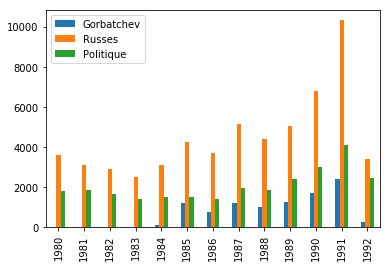

In [50]:
keywords = ["Gorbatchev", "Gorbatchov","Russie", "URSS", "Moscou", "soviétique","politique", "économie", "PCUS", "Perestroika", "Glasnot", "Glasnost"]
dates = [1982, 1987, 1983, 1986, 1980, 1985, 1981, 1984, 1991, 1988, 1990,1989, 1992] # dates in this python folder
corpus1, occ1 = read_archive(keywords)

keys = ["Gorbatchev", "Russes", "Politique"]
occ = concatOcc(keywords, keys, occ1)
plot_occurences(occ, keys, dates, "corpus1")

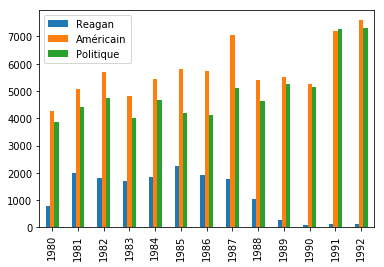

In [51]:
keywords = ["Reagan", "Etats-Unis", "USA", "Amerique", "Washington", "politique", "économie", "pershing"]
corpus2, occ2 =read_archive(keywords)

keys = ["Reagan", "Américain", "Politique"]
occ = concatOcc(keywords, keys, occ2)
plot_occurences(occ, keys, dates, "corpus2")

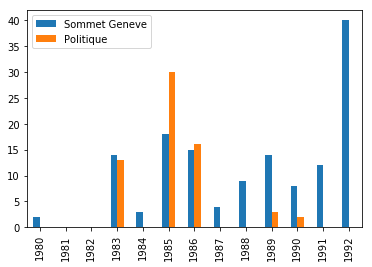

In [52]:
keywords = ["Sommet", "Geneve", "Reagan", "Gorbatchev", "Gorbatchov", "Moscou", "Washington"]
corpus3, occ3 =read_archive(keywords)

keys = ["Sommet Geneve", "Politique"]
occ = concatOcc(keywords, keys, occ3)
plot_occurences(occ, keys, dates, "corpus3")

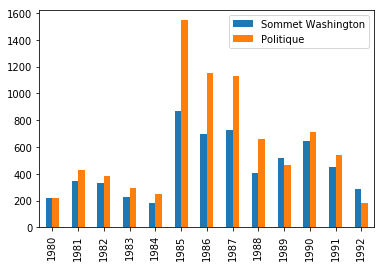

In [56]:
keywords = ["Sommet", "Washington", "Reagan", "Gorbatchev", "Gorbatchov", "Moscou", "Washington"]
corpus4, occ4 =read_archive(keywords)

keys = ["Sommet Washington", "Politique"]
occ = concatOcc(keywords, keys, occ4)
plot_occurences(occ, keys, dates, "corpus4")

In [55]:
print(len(corpus1))
print(len(corpus2))
print(len(corpus3))
print(len(corpus4))

13271
32200
55
10495


JDG-1982-reduced.jsonl.bz2
JDG-1987-reduced.jsonl.bz2
JDG-1983-reduced.jsonl.bz2
JDG-1986-reduced.jsonl.bz2
JDG-1980-reduced.jsonl.bz2
JDG-1985-reduced.jsonl.bz2
JDG-1981-reduced.jsonl.bz2
JDG-1984-reduced.jsonl.bz2
JDG-1991-reduced.jsonl.bz2
JDG-1988-reduced.jsonl.bz2
JDG-1990-reduced.jsonl.bz2
JDG-1989-reduced.jsonl.bz2
JDG-1992-reduced.jsonl.bz2


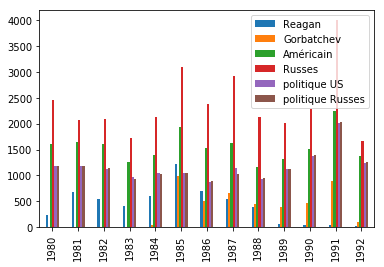

In [77]:
keywords = ["Reagan", "Gorbatchev", "Gorbatchov", "Etats-Unis", "USA", "Amérique", "Washington", "Russie", "URSS", "Moscou", "soviétique", "politique", "économie", "pershing", "politique", "économie", "PCUS", "Perestroika", "Glasnot"]

corpus5, occ5 = read_archive(keywords)

keys = ["Reagan", "Gorbatchev", "Américain", "Russes", "politique US", "politique Russes"]

occ = concatOcc(keywords, keys, occ5)
plot_occurences(occ, keys, dates, "corpus5")

In [61]:
keywords = ["Reagan", "Gorbatchev", "Gorbatchov", "Etats-Unis", "USA", "Amérique", "Washington", "Russie", "URSS", "Moscou", "soviétique", "politique", "économie", "pershing", "politique", "économie", "PCUS", "Perestroika", "Glasnot"]

print([keywords[0]])
print(keywords[1:3])
print(keywords[3:7])
print(keywords[7:11])
print(keywords[11:14])
print(keywords[14:18])

keys = ["Reagan", "Gorbatchev", "Américain", "Russes", "politique US", "politique Russes"]




['Reagan']
['Gorbatchev', 'Gorbatchov']
['Etats-Unis', 'USA', 'Amérique', 'Washington']
['Russie', 'URSS', 'Moscou', 'soviétique']
['politique', 'économie', 'pershing']
['politique', 'économie', 'PCUS', 'Perestroika']


In [71]:
for article in corpus4:
    json_article = json.loads(article)
    print(json_article["id"] + " " + json_article["fulltext"][0:550] + "\n\n")

JDG-1982-12-22-a-i0004 AFRIQUE DE L'OUEST 4 sommets en 72 heures Yamoussokro, 20 (Reuter / AFP).-Les confé rences des chefs d'Etat de la Communauté économique de l'Afrique de l'Ouest (CEAO), de l'Accord de non-agression et d'assistance en matière de défense (ANAD) et de l'Union monétaire ouest-africaine (UMOA) se sont achevées lundi à Yamoussokro, en Côte-d'Ivoire. Huit chefs d'Etat ont tenu ces 3 sommets en moins de 48 heures : les présidents Mathieu Kerekou (Bénin), Félix Houphouët-Boigny (Côte d'Ivoire), Jean-Baptiste Ouedraogo (te-Volta), Moussa Traore (Mali), Kh


JDG-1982-06-14-a-i0003 LIBAN Les Palestiniens définitivement muselés ? De Beyrouth : Joseph Chami En dépit d'inévitables bavures, le cessez le-feu israélo-palestinien entré en vigueur dans la nuit de samedi devrait, sauf accident ou impondérable, durer au moins quelque temps, estime-t-on généralement ici. Car Israël a déjà atteint ses principaux objectifs et l'OLP perdu ses dernières illusions. C'est le chef de la centra

30169


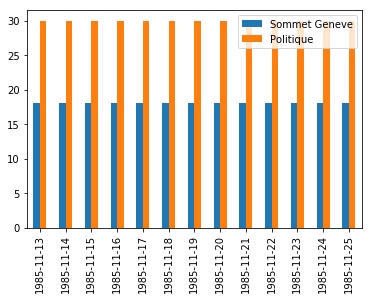

In [90]:
# corpus 3 bis on good dates

keywords = ["Sommet", "Geneve", "Reagan", "Gorbatchev", "Gorbatchov", "Moscou", "Washington"]
#corpus3, occ3 =read_archive(keywords)

keys = ["Sommet Geneve", "Politique"]
#occ = concatOcc(keywords, keys, occ3)
#plot_occurences(occ, keys, dates, "corpus3bis")


path = "data/JDG-1985-reduced.jsonl.bz2"
f = BZ2File(path, 'r')
articles = list(read_jsonlines(f))

d1 = date(1985, 11, 13)
d2 = date(1985, 11, 25)
# dates = ["1985-11-13", "1985-11-25"]
dates = string_dates(d1, d2)


corpus3bis, occ3bis = study_file(path, dates, keywords)

occ = concatOcc(keywords, keys, occ3bis)
plot_occurences(occ, keys, dates, "corpus3bis")




print(len(articles))

36041


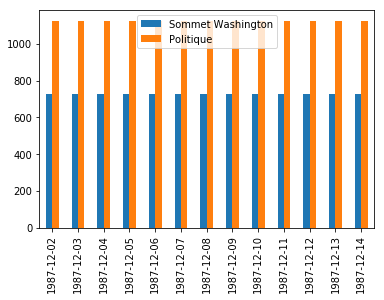

In [92]:
# corpus 4 bis on good dates

keywords = ["Sommet", "Washington", "Reagan", "Gorbatchev", "Gorbatchov", "Moscou", "Washington"]

#corpus3, occ3 =read_archive(keywords)

keys = ["Sommet Washington", "Politique"]
#occ = concatOcc(keywords, keys, occ3)
#plot_occurences(occ, keys, dates, "corpus3bis")


path = "data/JDG-1987-reduced.jsonl.bz2"
f = BZ2File(path, 'r')
articles = list(read_jsonlines(f))

d1 = date(1987, 12, 2)
d2 = date(1987, 12, 14)
# dates = ["1987-12-02", "1987-12-14"]
dates = string_dates(d1, d2)


corpus4bis, occ4bis = study_file(path, dates, keywords)

occ = concatOcc(keywords, keys, occ4bis)
plot_occurences(occ, keys, dates, "corpus4bis")




print(len(articles))

In [89]:
def study_file(filepath, dates, keywords):
    f = BZ2File(path, 'r')
    articles = list(read_jsonlines(f))
    # print("ENTER FUNCTION...")
    selected_articles = []
    ALLOCC = []
    for date in dates:
        occALLArticleOneDate = np.asarray([0] * len(keywords))
        
        for article in articles:
            json_article = json.loads(article)
            infos = json_article["id"]
            # print(infos)
            if str(date) in dates:
                if(isValid(json_article)):
                    selected, occurences = isSelected(json_article, keywords)
                    
                    if(selected):
                        # append to the return articles
                        selected_articles.append(article)
                        # add the occurences
                        occALLArticleOneDate += occurences

        ALLOCC.append(occALLArticleOneDate)
        
    return selected_articles, np.asarray(ALLOCC)
        
    

In [93]:
for article in articles:
        json_article = json.loads(article)
        infos = json_article["id"]

        for date in dates:
            if str(date) in infos:
                if(isValid(json_article)):
                    selected, occurences = isSelected(json_article, keywords)
                    
                    if(selected):
                        # append to the return articles
                        selected_articles.append(article)
                        # add the occurences
                        occALLArticleOneArchive += occurences

    

NameError: name 'selected_articles' is not defined

In [94]:
print(len(corpus3bis))
print(len(corpus4bis))

78
2366


In [99]:
for article in corpus4bis:
    json_article = json.loads(article)
    print(json_article["id"][6:14] + " "+ json_article["fulltext"][0:50])



87-12-12 LA FIN DU SOMMET DE WASHINGTON Un traité et beauco
87-12-12 Après Washington une longue chaîne d'inconnues par
87-12-12 La caution unanime de l'Otan masque mal ses diverg
87-12-12 Pour l'Italie : à l'Europe de jouer La majorité et
87-06-01 A quinze jours des élections les jeux sont loin d'
87-06-01 CUBA-ETATS-UNIS Pino Dîaz : une mine d'or pour les
87-06-01 VENISE Sommet des sept : priorité aux problèmes éc
87-12-16 GUERRES Echantillon d'apocalypse Le hasard fait pa
87-12-16 Violence basque : l'engrenage De Madrid : Ghristia
87-12-16 APRÈS LE SOMMET DE WASHINGTON George Shuitz remerc
87-12-16 Les Soviétiques pavoisent Si les journaux de ce we
87-12-16 CONJONCTURE Etats-Unis : « Récession pour fin 1988
87-12-17 Washington reprend la production d'armes chimiques
87-04-02 PAYS INDUSTRIALISÉS Groupe des Sept : l'Italie par
87-08-03 TÉLÉGRAMMES AMÉRIQUE CENTRALE RELANCE DU GROUPE DE
87-03-19 FILIÈRE IRANIENNE MM. Poindexter et North obtienne
87-05-13 IRANGATE ET AFRIQUE DU SUD IVIi

87-02-05 MONNAIES Rencontre monétaire en vue Washington, 4 
87-11-21 DÉSARMEMENT Rencontre au sommet à Genève Les minis
87-11-23 M. Chevardnadze : « Restent les questions difficil
87-04-11 JAPON Excédent commercial nippon : record en 1986 
87-04-13 Au pied d'un ordre du jour surchargé De Washington
87-11-19 GENÈVE Euromissiles : les problèmes de vérificatio
87-11-19 M. Gorbatchev pourrait être invité à s'adresser au
87-11-20 Le Congrès américain fixe une limite au développem
87-11-20 AMÉRIQUE LATINE Un sommet latino-américain sur la 
87-11-20 AFRIQUE DE L'OUEST Violents affrontements au Sahar
87-04-16 DÉSARMEMENT M. Shultz se félicite des « progrès co
87-12-18 L'âge de l'ayatollah Les rumeurs sur la mort de l'
87-08-15 ÉTATS-UNIS Nouvelle dégradation de la balance comm
87-05-15 Etats-Unis Faible rendement Au mois d'avril, Wall 
87-05-04 CONFLIT COMMERCIAL Les tensions demeurent entre To
87-04-27 DÉPART À LA RETRAITE f « Deux jeunes pour un Vieux
87-04-27 Et revoilà les métaux précieux 